The Huth et al. study makes conclusions about semantic representations based on the finding that word representations can predict voxel activity in semantic regions with some substantial probability. How surprising is this given that their word representations are giant and noisy?

In [1]:
import numpy as np
import scipy
import matplotlib.pyplot as plt
%matplotlib inline

## Word representations

The word representations are estimated by building a co-occurrence matrix between the 985 most common English words (the words of interest in this study) and the ~10,000 unique words that appear in a large multi-domain text corpus (including the *Moth Radio Hour* text used in the stimuli in this study).

[NOT YET, but hopefully:] The authors were kind enough to provide me with the resulting word embedding matrix.

For now, let's use [word2vec embeddings](https://drive.google.com/file/d/0B7XkCwpI5KDYNlNUTTlSS21pQmM/edit).

In [ ]:
# Let's use word2vec embeddings for now.

## HRF synthesis

(Stealing code from this tutorial on HRF generation in Python: http://www.jarrodmillman.com/rcsds/lectures/convolution_background.html)

In [2]:
from scipy.stats import gamma

In [3]:
def hrf(times, shift=0):
    """Compute HRF function with particular shift for the given times"""
    # Shift.
    times = times.copy()
    times -= shift
    
    # Gamma pdf for the peak
    peak_values = gamma.pdf(times, 6)
    # Gamma pdf for the undershoot
    undershoot_values = gamma.pdf(times, 12)
    # Combine them
    values = peak_values - 0.35 * undershoot_values
    # Scale max to 0.6
    return values / np.max(values) * 0.6

In [4]:
x = np.arange(0, 25, 0.1)

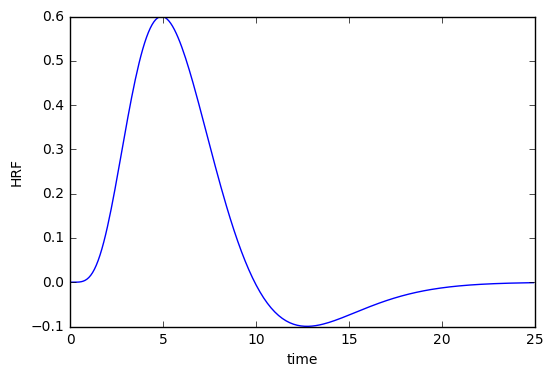

In [5]:
plt.plot(x, hrf(x))
plt.xlabel("time")
plt.ylabel("HRF")

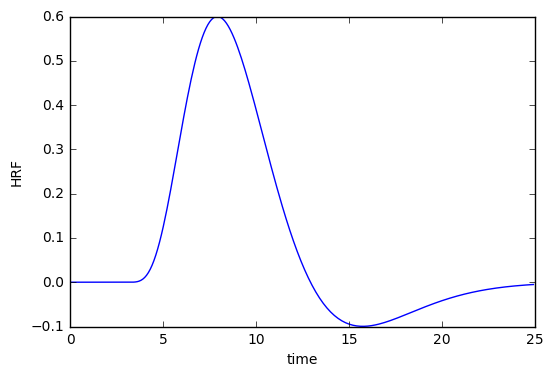

In [6]:
plt.plot(x, hrf(x, shift=3))
plt.xlabel("time")
plt.ylabel("HRF")

In [61]:
def convolved_hrf(times, shifts, weights):
    assert len(shifts) == len(weights)
    response = sum(hrf(times, shift=shift) * weight
                   for shift, weight in zip(shifts, weights))
    return response

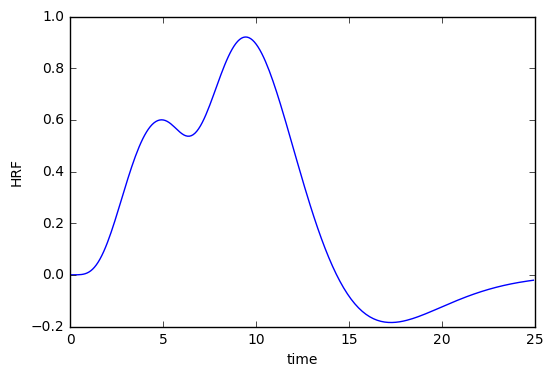

In [62]:
plt.plot(x, convolved_hrf(x, [0, 5], [1, 1.5]))
plt.xlabel("time")
plt.ylabel("HRF")

### Sampling from our HRFs

In [63]:
TR = 2.0
x_realistic = np.arange(0, 25, TR)

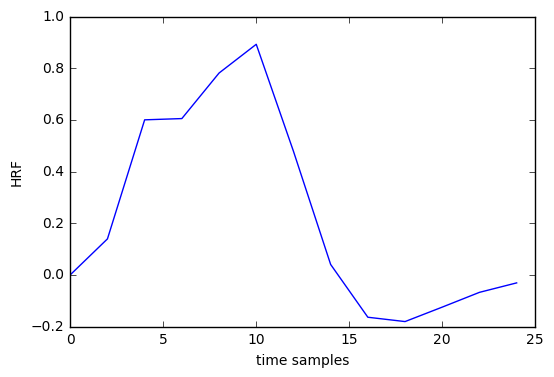

In [64]:
plt.plot(x_realistic, convolved_hrf(x_realistic, [0, 5], [1, 1.5]))
plt.xlabel("time samples")
plt.ylabel("HRF")

### Generating random voxel data

In [68]:
def random_voxel_data(times, events, mu_lag=5.0, sigma_lag=0.1,
                      alpha_signal=1, beta_signal=1,
                      p_noise=0.5, TR=2.0):
    """
    Generate random voxel drawn from a synthetic HRF model.
    
    p ~ Beta(`alpha_signal`, `beta_signal`)
    
    For each event, with probability `p` this event triggers an HRF
    response in the voxel.
    
    Args:
        times: Sample times.
        events: List of real-valued time points (not samples) at which known events occurred
        mu_lag: Mean of HRF lag Gaussian distribution
        sigma_lag: Standard deviation of HRF lag Gaussian distribution
        alpha_signal: Parameter for a Beta signal prior. See above description.
        beta_signal: Parameter for a Beta signal prior. See above description.
        p_noise: Geometric parameter indicating probability of voxel containing a significant noise signal
        TR: Time interval between samples
    """
    # Trial length
    length = times.max() - times.min()
    
    # Filter events that should yield signals.
    p_signal = np.random.beta(alpha_signal, beta_signal)
    events = np.array(events)[np.random.random(len(events)) < p_signal]
    # Shift events with time lag.
    hrf_points = events + np.random.normal(mu_lag, sigma_lag, size=len(events))
    weights = np.random.normal(1.0, 0.3, size=len(events))
    
    # Sample noise responses
    n_noise = np.random.geometric(p_noise)
    noise_lags = np.random.normal(mu_lag, sigma_lag, size=n_noise)
    # Randomly distribute across time
    noise_times = np.random.uniform(0 - noise_lags.max(), length - noise_lags.max(), size=n_noise)
    noise_hrf_points = noise_times + noise_lags
    noise_weights = np.maximum(0.05, np.random.normal(0.5, 0.3, size=len(noise_times)))
    
    if n_noise > 0:
        hrf_points = np.concatenate((hrf_points, noise_hrf_points))
        weights = np.concatenate((weights, noise_weights))
    print(hrf_points)
    print(weights)
    return convolved_hrf(times, hrf_points, weights)

[  5.13228061  33.9092055 ]
[ 1.20604025  0.89281834]


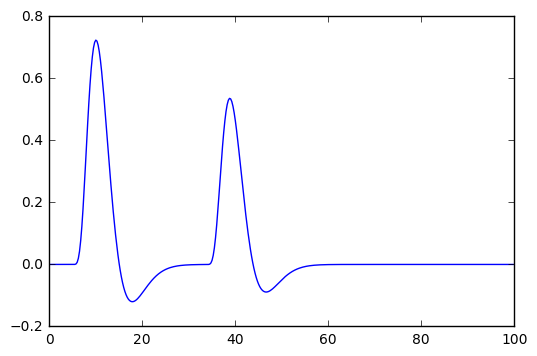

In [75]:
x = np.arange(0, 100, 0.25)
plt.plot(x, random_voxel_data(x, [0, 2, 15, 37]))